In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from database.connection import sql_connection
from database.dataset import dataset_config
import lightgbm as lgb
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization
from plots import plots

import numpy as np
import pandas as pd

In [2]:
random_state=1
stdrings = sql_connection.set_standard_rings_data()
qrings=sql_connection.set_quarter_rings_data()
# params=[[{'cluster_eta':[0.6, 0.8]}, {'cluster_et':[20000,30000]}],
#         [{'cluster_eta':[1.2, 1.8]}, {'cluster_et':[100000, 250000]}]]

# Definição dos bins de entrada
bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000, 900000, 3000000]}
bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5]}

# Lista para armazenar o resultado final
params = []

# Extrai as listas de valores dos dicionários
et_values = bins_et['cluster_et']
eta_values = bins_eta['cluster_eta']

# Itera sobre cada intervalo de eta (ex: [0, 0.6], [0.6, 0.8], ...)
for i in range(len(eta_values) - 1):
    eta_interval = [eta_values[i], eta_values[i+1]]
    
    # Para cada intervalo de eta, itera sobre cada intervalo de et
    for j in range(len(et_values) - 1):
        et_interval = [et_values[j], et_values[j+1]]
        
        # Cria a estrutura de dicionário para a combinação atual
        param_combination = [
            {'cluster_eta': eta_interval},
            {'cluster_et': et_interval}
        ]
        
        # Adiciona a combinação à lista final
        params.append(param_combination)
print(len(params))

dataset=dataset_config.split_dataframe(stdrings, params=params)
stdrings_data = dataset_config.prepare_and_split_data(
    input_type='std_rings',
    stdrings_df=dataset,
    train_size= 0.7,
    random_state=random_state
)

qrings_data= dataset_config.prepare_and_split_data(
    input_type='quarter_rings',
    stdrings_df=stdrings,
    qrings_df=qrings,
    train_size= 0.7,
    mode='delta',
    random_state=random_state
    )

DatabaseError: Execution failed on sql 'SELECT * FROM events': no such table: events

In [ ]:
space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 1000),
    Integer(name='max_depth', low = 200, high = 1000),
    Real(name='feature_fraction', low = 0.5 , high = 1),
    Real(name='bagging_fraction', low = 0.7 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.5, high = 1)
]

fixed_params_lgbm = {
    "boosting_type": "gbdt",
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 500,
    'random_state': random_state, 
    'n_jobs': -1, 
    'verbose': -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=5, verbose=False)]}
optimization_kwargs = {'n_initial_points': 15,
                        'n_calls': 50,
                        'initial_point_generator': 'lhs',
                        'random_state': random_state,

                       
                       }
# bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000, 900000, 3000000]}
# bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5]}

parameters_run_model = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 30,
    "max_depth": 7,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "verbosity": -1
}

parameters_run_model_1 = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 139,
    "max_depth": 300,
    "learning_rate": 0.095,
    "feature_fraction": 0.8,
    "bagging_fraction": 1,
    "bagging_freq": 10,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.02,
    "lambda_l2": 0.72,
    "force_row_wise": True,
    "verbosity": -1
}

parameters_run_model_2 = {
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': ['mae'],
    'num_leaves': np.int64(652),
    'max_depth': np.int64(610),
    'learning_rate': 0.03818654645154271,
    'feature_fraction': 0.9039401105949553,
    'bagging_fraction': 0.7960565139652669,
    'bagging_freq': np.int64(6),
    'num_boost_round': np.int64(534),
    'early_stopping_rounds': 5,
    'lambda_l1': 0.4069025545005863,
    'lambda_l2': 0.6767363223435275,
    'force_row_wise': True,
    'verbosity': -1}


In [4]:
optimizer_lgbm = RunOptimization()
results=optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=stdrings_data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs
)


Iteração 0 → shape parcial: (562, 4)
   cluster_eta → min: -0.5979943871498108, max: 0.5978778004646301
   cluster_et  → min: 5015.876953125, max: 9979.70703125
Iteração 1 → shape parcial: (1826, 4)
   cluster_eta → min: -0.5994063019752502, max: 0.5996809005737305
   cluster_et  → min: 10008.0185546875, max: 19987.404296875
Iteração 2 → shape parcial: (1816, 4)
   cluster_eta → min: -0.5997311472892761, max: 0.5986987948417664
   cluster_et  → min: 20006.333984375, max: 29996.8984375
Iteração 3 → shape parcial: (1875, 4)
   cluster_eta → min: -0.5988233089447021, max: 0.5996241569519043
   cluster_et  → min: 30004.7109375, max: 39998.71484375
Iteração 4 → shape parcial: (1833, 4)
   cluster_eta → min: -0.599497377872467, max: 0.5982772707939148
   cluster_et  → min: 40002.27734375, max: 49999.125
Iteração 5 → shape parcial: (3663, 4)
   cluster_eta → min: -0.5999965071678162, max: 0.598859429359436
   cluster_et  → min: 50000.46875, max: 69998.5859375
Iteração 6 → shape parcial: (5549

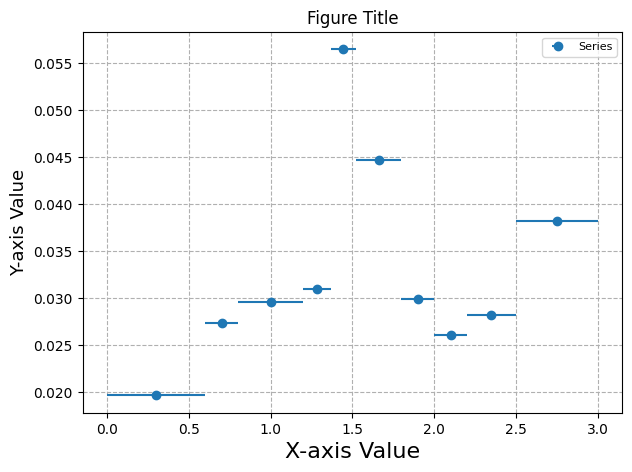

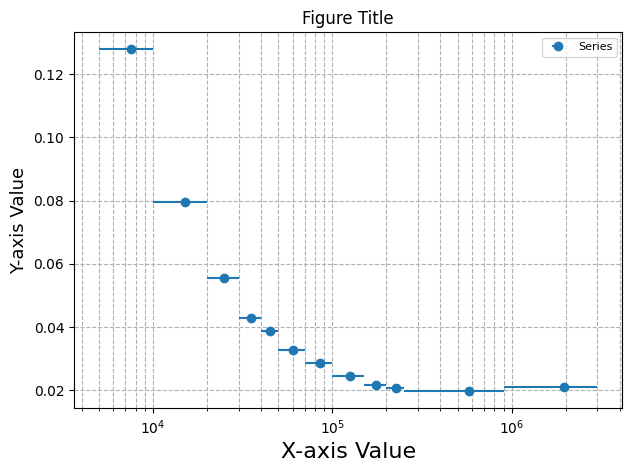

In [6]:
merged_dataframe=[]

for i in range(len(optimizer_lgbm.optimizer)):
    optimizer_lgbm.optimizer[i].fit_best_model() 
    
    df_temp = plots.merge_dataframes(
        stdrings.loc[optimizer_lgbm.optimizer[i].y_test.index],
        optimizer_lgbm.optimizer[i].y_test,
        optimizer_lgbm.optimizer[i].y_pred
    )
    merged_dataframe.append(df_temp)
    print("Iteração", i, "→ shape parcial:", df_temp.shape)
    
    # Calcular min e max apenas desta iteração
    eta_min, eta_max = df_temp['cluster_eta'].min(), df_temp['cluster_eta'].max()
    et_min, et_max   = df_temp['cluster_et'].min(), df_temp['cluster_et'].max()
    
    print(f"   cluster_eta → min: {eta_min}, max: {eta_max}")
    print(f"   cluster_et  → min: {et_min}, max: {et_max}")

merged_dataframes = pd.concat(merged_dataframe, ignore_index=True)
print(merged_dataframes.columns)
print(merged_dataframes.shape)
# Aplicando o filtro
df_filtrado = merged_dataframes[
    (merged_dataframes['cluster_et'] >= 50000) & 
    (merged_dataframes['cluster_et'] <= 70000)
]

# Exibindo o shape do filtrado
print("Shape do dataframe filtrado:", df_filtrado.shape)


bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5, 3]}
bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000, 900000, 3000000]}

et_metric=plots.parameters_filter(merged_dataframes, bins_et)
eta_metric=plots.parameters_filter(merged_dataframes, bins_eta)
print(len(et_metric))
print(len(eta_metric))
et_plot=plots.evaluate_metrics(et_metric, y_test_col='alpha', y_pred_col='y_pred')
eta_plot=plots.evaluate_metrics(eta_metric, y_test_col='alpha', y_pred_col='y_pred')

eta_plot_params={'y_data': eta_plot,}
et_plot_params={'y_data': et_plot,}

print(eta_plot_params)
print(et_plot_params)

plots.plot_errorbars(plot_configs=[eta_plot_params,],bins=bins_eta)
plots.plot_errorbars(plot_configs=[et_plot_params, ],bins=bins_et,xscale='log')

In [ ]:
# merged_dataframe_lgbm_models=[]
# # PRETRAINED_MODEL_PATH = r'D:\Doutorado\calibration\calibration_refactor\debug_code\standartRINGS.txt'
# # loaded_booster = lgb.Booster(model_file=PRETRAINED_MODEL_PATH)

# lgbm_model = RunModel()
# results_lgbm_model=lgbm_model.run(
#     model_class="lgbm",
#     datasets=stdrings_data,
#     params=parameters_run_model_2,
#     calibration_kwargs= calibration_kwargs
# )
# for i in range(len(lgbm_model.models)):
#     lgbm_model.models[i].predict()
#     #lgbm_model.models[i].predict(loaded_booster)
#     print(type(lgbm_model.models[i].X_test))
#     print(type(lgbm_model.models[i].y_test))
#     if lgbm_model.models[i].X_test.index.equals(stdrings.loc[lgbm_model.models[i].y_test.index].index):
#         print("Índices são iguais")
#     else:
#         print("Índices são diferentes")


#     merged_dataframe_lgbm_models.append(plots.merge_dataframes(
#         stdrings.loc[lgbm_model.models[i].y_test.index],
#         lgbm_model.models[i].y_test, 
#         lgbm_model.models[i].y_pred)
#     )
# merged_dataframe_lgbm_models = pd.concat(merged_dataframe_lgbm_models, ignore_index=True)
# print(merged_dataframe_lgbm_models.columns.to_list())

# et_metric_models=plots.parameters_filter(merged_dataframe_lgbm_models, bins_et)
# eta_metric_models=plots.parameters_filter(merged_dataframe_lgbm_models, bins_eta)
# et_plot_models=plots.evaluate_metrics(et_metric_models, y_test_col='alpha', y_pred_col='y_pred')
# eta_plot_models=plots.evaluate_metrics(eta_metric_models, y_test_col='alpha', y_pred_col='y_pred')
# print(len(et_metric_models))
# print(len(eta_metric_models))
# et_plot_params_models={'y_data': et_plot_models,}
# eta_plot_params_models={'y_data': eta_plot_models,}


# print(eta_plot_params_models)
# print(et_plot_params_models)

In [ ]:
# qrings_merged_dataframe_lgbm_models=[]
# # PRETRAINED_MODEL_PATH = r'D:\Doutorado\calibration\calibration_refactor\debug_code\standartRINGS.txt'
# # loaded_booster = lgb.Booster(model_file=PRETRAINED_MODEL_PATH)

# qrings_lgbm_model = RunModel()
# qrings_results_lgbm_model=qrings_lgbm_model.run(
#     model_class="lgbm",
#     datasets=qrings_data,
#     params=parameters_run_model_2,
#     calibration_kwargs= calibration_kwargs
# )
# for i in range(len(qrings_lgbm_model.models)):
#     qrings_lgbm_model.models[i].predict()
#     #lgbm_model.models[i].predict(loaded_booster)
#     print(type(qrings_lgbm_model.models[i].X_test))
#     print(type(qrings_lgbm_model.models[i].y_test))

#     qrings_merged_dataframe_lgbm_models.append(plots.merge_dataframes(
#         qrings.loc[qrings_lgbm_model.models[i].y_test.index],
#         qrings_lgbm_model.models[i].y_test, 
#         qrings_lgbm_model.models[i].y_pred)
#     )
# qrings_merged_dataframe_lgbm_models = pd.concat(qrings_merged_dataframe_lgbm_models, ignore_index=True)
# print(qrings_merged_dataframe_lgbm_models.columns.to_list())

# qrings_et_metric_models=plots.parameters_filter(qrings_merged_dataframe_lgbm_models, bins_et)
# qrings_eta_metric_models=plots.parameters_filter(qrings_merged_dataframe_lgbm_models, bins_eta)
# qrings_et_plot_models=plots.evaluate_metrics(qrings_et_metric_models, y_test_col='alpha', y_pred_col='y_pred')
# qrings_eta_plot_models=plots.evaluate_metrics(qrings_eta_metric_models, y_test_col='alpha', y_pred_col='y_pred')
# print(len(qrings_et_metric_models))
# print(len(qrings_eta_metric_models))
# qrings_et_plot_params_models={'y_data': qrings_et_plot_models,}
# qrings_eta_plot_params_models={'y_data': qrings_eta_plot_models,}


# print(qrings_eta_plot_params_models)
# print(qrings_et_plot_params_models)

In [ ]:
# def save_list_of_dfs_to_excel(dfs_list, output_file, prefix="Sheet"):
#     """
#     Salva uma lista de DataFrames em um único arquivo Excel.
#     Cada DataFrame vai para uma sheet diferente.

#     Parameters
#     ----------
#     dfs_list : list[pd.DataFrame]
#         Lista de DataFrames a serem salvos.
#     output_file : str
#         Caminho do arquivo .xlsx de saída.
#     prefix : str
#         Prefixo usado nos nomes das sheets (default: "Sheet").
#     """
#     with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
#         for i, df in enumerate(dfs_list, start=1):
#             sheet_name = f"{prefix}_{i}"
#             df.to_excel(writer, sheet_name=sheet_name, index=False)

# # Salvar as duas variáveis
# save_list_of_dfs_to_excel(et_metric_models, "et_metric_models.xlsx", prefix="et")
# save_list_of_dfs_to_excel(eta_metric_models, "eta_metric_models.xlsx", prefix="eta")


# file_path = "merged_dataframe_lgbm_models.xlsx"  # nome do arquivo de saída

# # Salvar DataFrame em Excel
# merged_dataframe_lgbm_models.to_excel(file_path, index=False)